In [87]:
import numpy as np
import math
import pandas as pd
import sklearn as sk
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

### Meta Data

In this competition you are predicting the probability that an online transaction is fraudulent, 
as denoted by the binary target isFraud. The data is broken into two files identity and transaction, 
which are joined by TransactionID. Not all transactions have corresponding identity information.

Categorical Features - Identity

- DeviceType
- DeviceInfo
- id_12 - id_38

Transaction Table *

- **TransactionDT**: timedelta from a given reference datetime (not an actual timestamp)
- **TransactionAmt**: transaction payment amount in USD
- **ProductCD**: product code, the product for each transaction
- **card1 - card6**: payment card information, such as card type, card category, issue bank, country, etc.
- **addr1, addr2**: “both addresses are for purchaser; addr1 as billing region; addr2 as billing country”
- **dist: distance**; "distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”
- **P_ and (R__) emaildomain**: purchaser and recipient email domain (certain transactions don't need recipient, so R_emaildomain is null.)
- **C1-C14**: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. (maybe counts of phone numbers, email addresses, names associated with the user, device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.)
- **D1-D15**: timedelta, such as days between previous transaction, etc.
- **M1-M9**: match, such as names on card and address, etc.
- **Vxxx**: Vesta engineered rich features, including ranking, counting, and other entity relations.

array([[<AxesSubplot:title={'center':'D1'}>]], dtype=object)

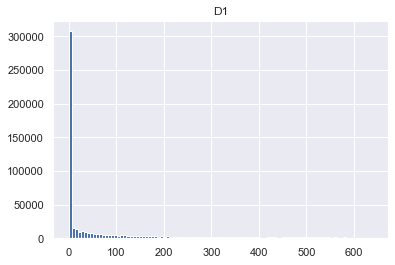

In [97]:
train_transaction[['D1']].hist(bins=100)

In [98]:
import seaborn as sns; sns.set_theme()
uniform_data = np.random.rand(10, 12)



c_data = train_transaction[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']]
c_pear_corr=c_data.corr(method='pearson')
c_pear_corr

d_data = train_transaction[['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']]
d_pear_corr=d_data.corr(method='pearson')
d_pear_corr

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
D1,1.000000,0.981311,0.280423,0.585714,0.055236,0.525691,0.204924,0.050165,0.007667,0.562145,0.592629,0.521104,0.370195,0.154799,0.638957
D2,0.981311,1.000000,0.266112,0.570017,0.238365,0.601299,0.454152,0.275304,0.042867,0.525967,0.563220,0.668833,0.394203,0.196670,0.618243
D3,0.280423,0.266112,1.000000,0.149038,0.707425,0.304947,0.818080,0.194211,0.006983,0.092362,0.055433,0.349025,0.136444,0.029219,0.141511
D4,0.585714,0.570017,0.149038,1.000000,0.313650,0.956966,0.574098,0.162900,0.041768,0.636928,0.657797,0.999999,0.383803,0.135268,0.751546
D5,0.055236,0.238365,0.707425,0.313650,1.000000,0.551310,0.986496,0.249365,0.031991,0.116784,0.058496,0.565222,0.134026,0.064274,0.188533
D6,0.525691,0.601299,0.304947,0.956966,0.551310,1.000000,0.506527,0.185532,0.040119,0.463143,NaN,0.976834,0.419894,0.207166,0.700615
D7,0.204924,0.454152,0.818080,0.574098,0.986496,0.506527,1.000000,0.223624,0.025509,0.107557,NaN,0.553886,0.123023,0.035528,0.285026
D8,0.050165,0.275304,0.194211,0.162900,0.249365,0.185532,0.223624,1.000000,0.066085,0.168607,NaN,0.157520,0.521432,0.080991,0.226635
D9,0.007667,0.042867,0.006983,0.041768,0.031991,0.040119,0.025509,0.066085,1.000000,0.063333,NaN,0.026858,0.024555,0.042368,0.054647
D10,0.562145,0.525967,0.092362,0.636928,0.116784,0.463143,0.107557,0.168607,0.063333,1.000000,0.609652,0.018188,0.277137,0.336933,0.712252


In [101]:
d_data

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,NaN,NaN,NaN,56.0
590536,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0
590537,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0
590538,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,NaN,NaN,NaN,22.0


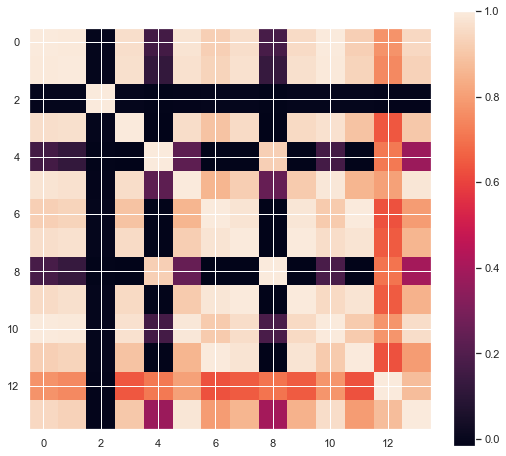

In [99]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(c_pear_corr, interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction = 0.05)

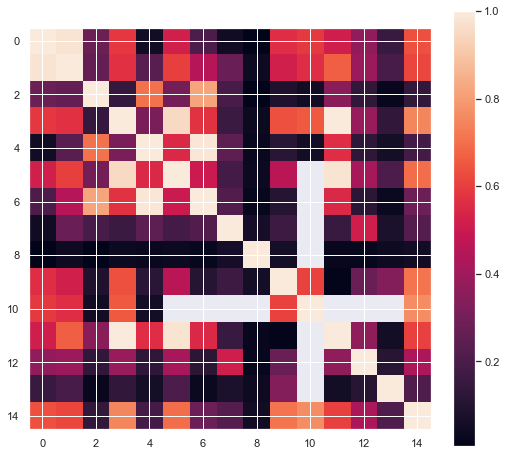

In [100]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(d_pear_corr, interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction = 0.05)

<ipython-input-96-1c5c8791aeae>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(our_data.columns, rotation=65, fontsize=20)
<ipython-input-96-1c5c8791aeae>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(our_data.columns, rotation=0, fontsize=20)


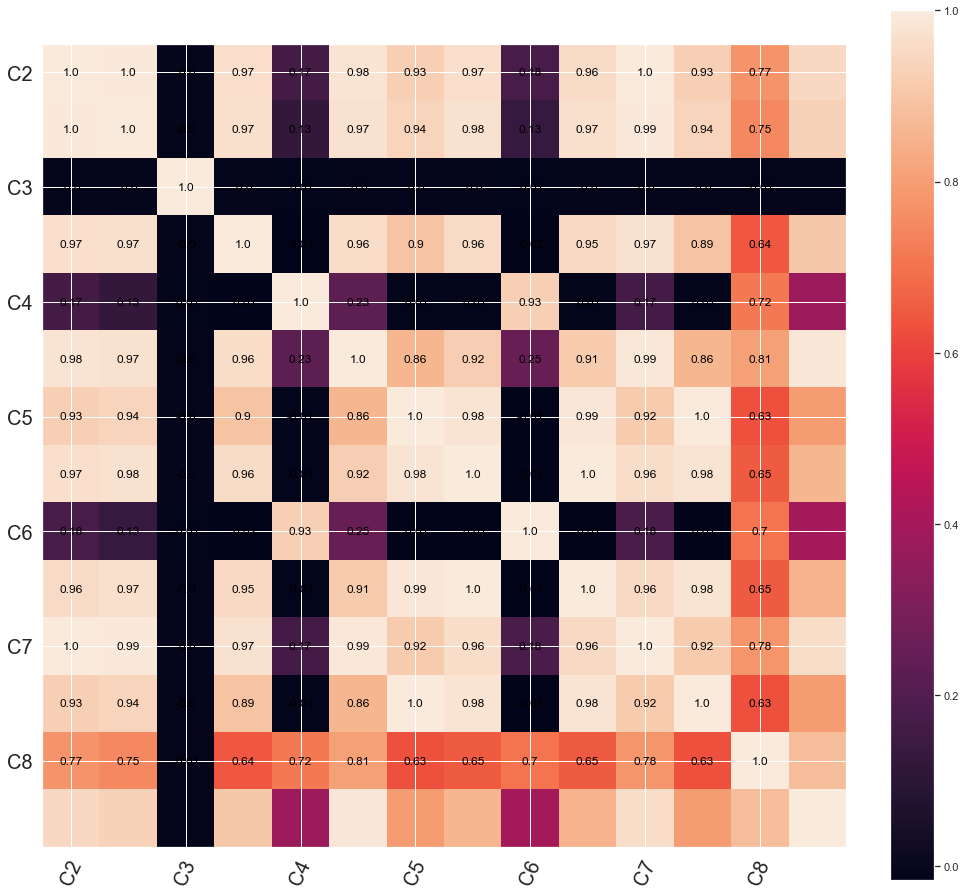

In [96]:
fig, ax = plt.subplots(figsize=(16,16))
im = ax.imshow(pear_corr, interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction = 0.05)

# Show all ticks and label them with the dataframe column name
ax.set_xticklabels(our_data.columns, rotation=65, fontsize=20)
ax.set_yticklabels(our_data.columns, rotation=0, fontsize=20)

# Loop over data dimensions and create text annotations
for i in range(len(our_data.columns)-1):
    for j in range(len(our_data.columns)-1):
        text = ax.text(j, i, round(pear_corr.to_numpy()[i, j], 2),
                       ha="center", va="center", color="black")

plt.show()

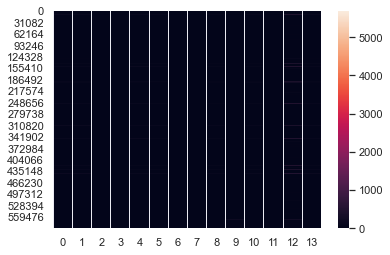

In [74]:
train_transaction[['C12']].value_counts()

C12   
0.0       489199
1.0        76661
2.0        12242
3.0         4185
4.0         1716
           ...  
1093.0         1
1094.0         1
1095.0         1
1096.0         1
3188.0         1
Length: 1199, dtype: int64

In [53]:
list(train_transaction.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

Identity Table *

- DeviceType
- DeviceInfo
- Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
- They're collected by Vesta’s fraud protection system and digital security partners.
- (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)
- id_01 - id_38

### Load Data

In [3]:
train_transaction_path = "data/train_transaction.csv"
train_identity_path = "data/train_identity.csv"
test_transaction_path = "data/test_transaction.csv"
test_identity_path = "data/test_identity.csv"
sample_submission_path = "data/sample_submission.csv"

In [4]:
#read data
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)
test_transaction = pd.read_csv(test_transaction_path)
test_identity = pd.read_csv(test_identity_path)
sample_submission = pd.read_csv(sample_submission_path)

In [5]:
train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='outer')

In [6]:
train_transaction_row = train_transaction.shape[0]
train_transaction_col = train_transaction.shape[1]
train_identity_row = train_identity.shape[0]
train_identity_col = train_identity.shape[1]
train_df_row = train_df.shape[0]
train_df_col = train_df.shape[1]
print('Transaction Training DataFrame: {} rows & {} columns.'.format(train_transaction_row, train_transaction_col))
print('Identity Training DataFrame: {} rows & {} columns.'.format(train_identity_row, train_identity_col))
print('Training DataFrame: {} rows & {} columns.'.format(train_df_row, train_df_col))

Transaction Training DataFrame: 590540 rows & 394 columns.
Identity Training DataFrame: 144233 rows & 41 columns.
Training DataFrame: 590540 rows & 434 columns.


In [7]:
train_df.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=434)

### Categorical Data

In [105]:
identity_col = train_identity.columns
transaction_col = train_transaction.columns
train_df[train_df.columns[train_df.dtypes==object]].head(2)

,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,NotFound,New,NotFound,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,2220x1080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NotFound,New,NotFound,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,1334x750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
train_transaction[train_transaction.columns[train_transaction.dtypes==object]].head(2)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN


In [30]:
train_identity[train_identity.columns[train_identity.dtypes==object]].head(2)

,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,NotFound,New,NotFound,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,NotFound,New,NotFound,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device


In [116]:
cat_train_df = train_df[train_df.columns[train_df.dtypes==object]]

In [117]:
cat_train_df['id_12'].value_counts().index[0]

'NotFound'

In [118]:
#returns a table with column name, unique value in each column, and the percentage of unique value in a column
def df_summary_cat(df):
    output = {'col_name': [], 'src': [], 'contain_nan': [], 'unique_val': [], 
              'unique_perc': [], 'null_val': [], 'null_perc': [], 
              'value': [], 'value_perc': [], 'most_common': [], 'redundent_perc': [], 
              'examples': []}

    for i in df.columns:
        unique_val = df[i].nunique()
        if i in identity_col:
            src = 'ID'
        else:
            src = 'TR'
        unique_val_with_nan = len(df[i].unique())
        contain_nan = True if unique_val != unique_val_with_nan else False
        unique_perc = round(unique_val/df.shape[0] * 100, 3)
        null_val = df[i].isnull().sum()
        null_perc = round(null_val / df.shape[0] * 100, 2)
        #The most common value / number of rows
        if len(df[i].value_counts()) > 0:
            redundent_perc = round(df[i].value_counts().iloc[0] / df.shape[0] * 100, 2)
        else:
            redundent_perc = 100
        
        value_val = df[i].describe()['count']
        value_perc = round(value_val / df.shape[0] * 100, 2)
        
        examples_func = lambda x : list(df[i].value_counts().index) if (x <= 4) else list(df[i].value_counts().index[:4])
        examples = examples_func(unique_val)
        output['col_name'].append(i)
        output['src'].append(src)
        output['contain_nan'].append(contain_nan)
        output['unique_val'].append(unique_val)
        output['unique_perc'].append(str(unique_perc) + '%')
        output['null_val'].append(null_val)
        output['null_perc'].append(str(null_perc) + '%')
        output['redundent_perc'].append(str(redundent_perc) + '%')
        output['value'].append(value_val)
        output['value_perc'].append(str(value_perc) + '%')
        output['most_common'].append(df[i].value_counts().index[0])
        output['examples'].append(examples)
    return pd.DataFrame(output)

In [119]:
cat_summary_df = df_summary_cat(cat_train_df)

In [120]:
cat_summary_df

,col_name,src,contain_nan,unique_val,unique_perc,null_val,null_perc,value,value_perc,most_common,redundent_perc,examples
0,id_12,ID,True,2,0.0%,446307,75.58%,144233,24.42%,NotFound,20.83%,"[NotFound, Found]"
1,id_15,ID,True,3,0.001%,449555,76.13%,140985,23.87%,Found,11.47%,"[Found, New, Unknown]"
2,id_16,ID,True,2,0.0%,461200,78.1%,129340,21.9%,Found,11.23%,"[Found, NotFound]"
3,id_23,ID,True,3,0.001%,585371,99.12%,5169,0.88%,IP_PROXY:TRANSPARENT,0.59%,"[IP_PROXY:TRANSPARENT, IP_PROXY:ANONYMOUS, IP_..."
4,id_27,ID,True,2,0.0%,585371,99.12%,5169,0.88%,Found,0.87%,"[Found, NotFound]"
5,id_28,ID,True,2,0.0%,449562,76.13%,140978,23.87%,Found,12.91%,"[Found, New]"
6,id_29,ID,True,2,0.0%,449562,76.13%,140978,23.87%,Found,12.69%,"[Found, NotFound]"
7,id_30,ID,True,75,0.013%,512975,86.87%,77565,13.13%,Windows 10,3.58%,"[Windows 10, Windows 7, iOS 11.2.1, iOS 11.1.2]"
8,id_31,ID,True,130,0.022%,450258,76.25%,140282,23.75%,chrome 63.0,3.73%,"[chrome 63.0, mobile safari 11.0, mobile safar..."
9,id_33,ID,True,260,0.044%,517251,87.59%,73289,12.41%,1920x1080,2.86%,"[1920x1080, 1366x768, 1334x750, 2208x1242]"


### Quantitative Data

In [109]:
quant_train_df = train_df[train_df.columns[train_df.dtypes!=object]]

In [110]:
def df_summary_quan(df):
    output = {'col_name': [], 'src': [], 'contain_nan': [], 'unique_val': [], 
              'unique_perc': [], 'null_val': [], 'null_perc': [], 'redundent_perc': [],
              'value': [], 'value_perc': [], 'mean': [], 'max': [], 'min': [], 'std': [], 
              '25%': [], '50%': [], '75%': [], 'examples': []}

    for i in df.columns:
        unique_val = df[i].nunique()
        if i in identity_col:
            src = 'ID'
        else:
            src = 'TR'
        unique_val_with_nan = len(df[i].unique())
        contain_nan = True if unique_val != unique_val_with_nan else False
        unique_perc = round(unique_val/df.shape[0] * 100, 3)
        null_val = df[i].isnull().sum()
        null_perc = round(null_val / df.shape[0] * 100, 3)
        if len(df[i].value_counts()) > 0:
            redundent_perc = round(df[i].value_counts().iloc[0] / df.shape[0] * 100, 3)
        else:
            redundent_perc = 100
        
        value_val = df[i].describe()['count']
        value_perc = round(value_val / df.shape[0] * 100, 2)
        mean_val = df[i].describe()['mean']
        std_val = df[i].describe()['std']
        min_val = df[i].describe()['min']
        twenty_five = df[i].describe()['25%']
        fifty = df[i].describe()['50%']
        seventy_five = df[i].describe()['75%']
        max_val = df[i].describe()['max']
        
        examples_func = lambda x : list(df[i].value_counts().index) if (x <= 4) else list(df[i].value_counts().index[:4])
        examples = examples_func(unique_val)
        output['col_name'].append(i)
        output['src'].append(src)
        output['unique_val'].append(unique_val)
        output['contain_nan'].append(contain_nan)
        output['unique_perc'].append(unique_perc)
        output['null_val'].append(null_val)
        output['null_perc'].append(null_perc)
        output['redundent_perc'].append(redundent_perc)
        output['value'].append(value_val)
        output['value_perc'].append(value_perc)
        output['mean'].append(round(mean_val, 2))        
        output['max'].append(max_val)        
        output['min'].append(min_val)
        output['std'].append(std_val)
        output['25%'].append(twenty_five)
        output['50%'].append(fifty)
        output['75%'].append(seventy_five)
        output['examples'].append(examples)
    return pd.DataFrame(output)

In [111]:
quan_summary_df = df_summary_quan(quant_train_df).sort_values('null_perc', ascending=False)

In [112]:
quan_summary_df.head()
quan_cols = ['null_perc', 'redundent_perc']

In [113]:
df_summary_quan(d_data).sort_values('null_perc', ascending=False)

,col_name,src,contain_nan,unique_val,unique_perc,null_val,null_perc,redundent_perc,value,value_perc,mean,max,min,std,25%,50%,75%,examples
6,D7,TR,True,597,0.101,551623,93.410,3.579,38917.0,6.59,41.64,843.000000,0.0,99.743264,0.000000,0.000000,17.000000,"[0.0, 1.0, 2.0, 3.0]"
12,D13,TR,True,577,0.098,528588,89.509,8.270,61952.0,10.49,17.90,847.000000,0.0,67.614425,0.000000,0.000000,0.000000,"[0.0, 1.0, 26.0, 2.0]"
13,D14,TR,True,802,0.136,528353,89.469,7.665,62187.0,10.53,57.72,878.000000,-193.0,136.312450,0.000000,0.000000,2.000000,"[0.0, 1.0, 256.0, 2.0]"
11,D12,TR,True,635,0.108,525823,89.041,7.240,64717.0,10.96,54.04,648.000000,-83.0,124.274558,0.000000,0.000000,13.000000,"[0.0, 1.0, 2.0, 3.0]"
5,D6,TR,True,829,0.140,517353,87.607,7.753,73187.0,12.39,69.81,873.000000,-83.0,143.669253,0.000000,0.000000,40.000000,"[0.0, 1.0, 256.0, 2.0]"
7,D8,TR,True,12353,2.092,515614,87.312,0.229,74926.0,12.69,146.06,1707.791626,0.0,231.663840,0.958333,37.875000,187.958328,"[0.7916659712791443, 0.8333330154418945, 0.875..."
8,D9,TR,True,24,0.004,515614,87.312,0.912,74926.0,12.69,0.56,0.958333,0.0,0.316880,0.208333,0.666666,0.833333,"[0.7916659712791443, 0.8333330154418945, 0.75,..."
4,D5,TR,True,688,0.117,309841,52.467,11.071,280699.0,47.53,42.34,819.000000,0.0,89.000144,1.000000,10.000000,32.000000,"[0.0, 1.0, 2.0, 7.0]"
1,D2,TR,True,641,0.109,280797,47.549,2.561,309743.0,52.45,169.56,640.000000,0.0,177.315865,26.000000,97.000000,276.000000,"[0.0, 1.0, 2.0, 3.0]"
10,D11,TR,True,676,0.114,279287,47.293,19.013,311253.0,52.71,146.62,670.000000,-53.0,186.042622,0.000000,43.000000,274.000000,"[0.0, 1.0, 2.0, 3.0]"


### Filter Columns

In [154]:
#returns a table with column name, unique value in each column, and the percentage of unique value in a column
def df_summary(df):
    output = {'col_name': [], 'src': [], 'dtype' : [], 'unique_val': [], 'contain_nan': [],
              'unique_perc': [], 'null_val': [], 'null_perc': [], 'redundent_perc': [],
              'count': [], 'mean': [], 'max': [], 'min': [], 'std': [], 
              '25%': [], '50%': [], '75%': [], 'examples': []}

    for i in df.columns:
        unique_val = df[i].nunique()
        if i in identity_col:
            src = 'ID'
        else:
            src = 'TR'
        unique_val_with_nan = len(df[i].unique())
        contain_nan = True if unique_val != unique_val_with_nan else False
        unique_perc = round(unique_val/df.shape[0] * 100, 3)
        null_val = df[i].isnull().sum()
        null_perc = round(null_val / df.shape[0] * 100, 3)
        if len(df[i].value_counts()) > 0:
            redundent_perc = round(df[i].value_counts().iloc[0] / df.shape[0] * 100, 3)
        else:
            redundent_perc = 100
        
        if df[i].dtype == 'float64':
            count_val = df[i].describe()['count']
            mean_val = df[i].describe()['mean']
            std_val = df[i].describe()['std']
            min_val = df[i].describe()['min']
            twenty_five = df[i].describe()['25%']
            fifty = df[i].describe()['50%']
            seventy_five = df[i].describe()['75%']
            max_val = df[i].describe()['max']
        else:
            count_val = np.nan
            mean_val = np.nan
            std_val = np.nan
            min_val = np.nan
            twenty_five = np.nan
            fifty = np.nan
            seventy_five = np.nan
            max_val = np.nan
        
        examples_func = lambda x : list(df[i].value_counts().index) if (x <= 4) else list(df[i].value_counts().index[:4])
        examples = examples_func(unique_val)
        output['col_name'].append(i)
        output['src'].append(src)
        output['dtype'].append(df[i].dtype)
        output['unique_val'].append(unique_val)
        output['contain_nan'].append(contain_nan)
        output['unique_perc'].append(unique_perc)
        output['null_val'].append(null_val)
        output['null_perc'].append(null_perc)
        output['redundent_perc'].append(redundent_perc)
        output['count'].append(count_val)
        output['mean'].append(mean_val)        
        output['max'].append(max_val)
        output['min'].append(min_val)
        output['std'].append(std_val)
        output['25%'].append(twenty_five)
        output['50%'].append(fifty)
        output['75%'].append(seventy_five)
        output['examples'].append(examples)
    return pd.DataFrame(output)

In [155]:
summary_df = df_summary(train_df)

In [156]:
summary_df.head(5)

,col_name,src,dtype,unique_val,contain_nan,unique_perc,null_val,null_perc,redundent_perc,count,mean,max,min,std,25%,50%,75%,examples
0,TransactionID,ID,int64,590540,False,100.000,0,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[3145728, 3558300, 3041944, 3039897]"
1,id_01,ID,float64,77,True,0.013,446307,75.576,13.914,144233.0,-10.170502,0.0,-100.0,14.347949,-10.0,-5.0,-5.0,"[-5.0, 0.0, -10.0, -20.0]"
2,id_02,ID,float64,115655,True,19.585,449668,76.145,0.002,140872.0,174716.584708,999595.0,1.0,159651.816856,67992.0,125800.5,228749.0,"[1102.0, 696.0, 1120.0, 1141.0]"
3,id_03,ID,float64,24,True,0.004,524216,88.769,10.821,66324.0,0.060189,10.0,-13.0,0.598231,0.0,0.0,0.0,"[0.0, 1.0, 3.0, 2.0]"
4,id_04,ID,float64,15,True,0.003,524216,88.769,11.132,66324.0,-0.058938,0.0,-28.0,0.701015,0.0,0.0,0.0,"[0.0, -5.0, -6.0, -8.0]"


In [162]:
#Drop columns contains > 90% null observations
print("Null Value Percent > 90%: {} Columns".format(summary_df[(summary_df['null_perc']>90)].shape[0]))

Null Value Percent > 90%: 12 Columns


In [164]:
#Drop columns contains > 90% redundent information
print("Redundent Percent > 90%: {} Columns".format(summary_df[(summary_df['redundent_perc']>90)].shape[0]))

Redundent Percent > 90%: 55 Columns


In [169]:
#Drop columns contains > 90% null observations
#Drop columns contains > 90% redundent information

summary_df_clean = summary_df[(summary_df['null_perc']<=90) & (summary_df['redundent_perc']<=90)]

In [170]:
summary_df_clean.sort_values('null_perc', ascending=False)

,col_name,src,dtype,unique_val,contain_nan,unique_perc,null_val,null_perc,redundent_perc,count,mean,max,min,std,25%,50%,75%,examples
83,D13,TR,float64,577,True,0.098,528588,89.509,8.270,61952.0,17.901295,847.0,0.0,67.614425,0.0,0.0,0.0,"[0.0, 1.0, 26.0, 2.0]"
84,D14,TR,float64,802,True,0.136,528353,89.469,7.665,62187.0,57.724444,878.0,-193.0,136.312450,0.0,0.0,2.0,"[0.0, 1.0, 256.0, 2.0]"
82,D12,TR,float64,635,True,0.108,525823,89.041,7.240,64717.0,54.037533,648.0,-83.0,124.274558,0.0,0.0,13.0,"[0.0, 1.0, 2.0, 3.0]"
3,id_03,ID,float64,24,True,0.004,524216,88.769,10.821,66324.0,0.060189,10.0,-13.0,0.598231,0.0,0.0,0.0,"[0.0, 1.0, 3.0, 2.0]"
4,id_04,ID,float64,15,True,0.003,524216,88.769,11.132,66324.0,-0.058938,0.0,-28.0,0.701015,0.0,0.0,0.0,"[0.0, -5.0, -6.0, -8.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,C10,TR,float64,1231,False,0.208,0,0.000,76.784,590540.0,5.240343,3257.0,0.0,95.581443,0.0,0.0,0.0,"[0.0, 1.0, 2.0, 3.0]"
67,C11,TR,float64,1476,False,0.250,0,0.000,65.989,590540.0,10.241521,3188.0,0.0,94.336292,1.0,1.0,2.0,"[1.0, 2.0, 3.0, 4.0]"
68,C12,TR,float64,1199,False,0.203,0,0.000,82.839,590540.0,4.076227,3188.0,0.0,86.666218,0.0,0.0,0.0,"[0.0, 1.0, 2.0, 3.0]"
69,C13,TR,float64,1597,False,0.270,0,0.000,33.755,590540.0,32.539918,2918.0,0.0,129.364844,1.0,3.0,12.0,"[1.0, 2.0, 0.0, 3.0]"


In [93]:
summary_df[summary_df['redundent_perc']>=90] #redundent_perc > 90 && unique value < ???

,col_name,src,dtype,unique_val,contain_nan,unique_perc,null_val,null_perc,redundent_perc,count,mean,max,min,std,25%,50%,75%,examples
81,D11,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
92,M7,TR,object,0,True,0.000,144233,100.000,100.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
104,V10,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
53,dist1,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
103,V9,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,V299,TR,float64,50,True,0.035,2,0.001,92.467,144231.0,0.426094,49.0,0.0,3.341563,0.0,0.0,0.0,"[0.0, 1.0, 2.0, 3.0]"
41,isFraud,TR,int64,2,False,0.001,0,0.000,92.153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 1]"
59,C3,TR,float64,27,False,0.019,0,0.000,98.324,144233.0,0.023032,26.0,0.0,0.303819,0.0,0.0,0.0,"[0.0, 1.0, 2.0, 3.0]"
61,C5,TR,float64,1,False,0.001,0,0.000,100.000,144233.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,[0.0]


In [95]:
summary_df[summary_df['unique_val']<2]

,col_name,src,dtype,unique_val,contain_nan,unique_perc,null_val,null_perc,redundent_perc,count,mean,max,min,std,25%,50%,75%,examples
81,D11,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
92,M7,TR,object,0,True,0.000,144233,100.000,100.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
104,V10,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
53,dist1,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
103,V9,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
102,V8,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
101,V7,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
100,V6,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
99,V5,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
98,V4,TR,float64,0,True,0.000,144233,100.000,100.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]


In [ ]:
train_identity_box_df = train_identity.drop(columns=['TransactionID', 'id_02'])

In [ ]:
train_identity.head(2)

In [ ]:
train_transaction.head(2)

In [ ]:
train_df.head()

<AxesSubplot:xlabel='isFraud', ylabel='id_02'>

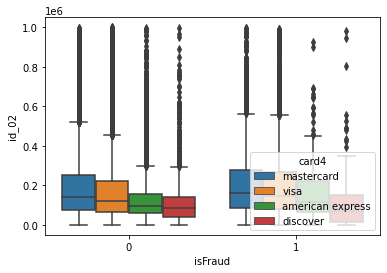

In [16]:
sns.boxplot(x = train_df['isFraud'],
            y = train_df['id_02'],
            hue = train_df['card4'])

<AxesSubplot:xlabel='card4', ylabel='id_02'>

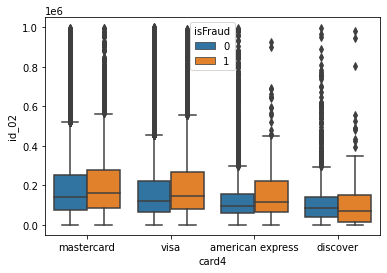

In [17]:
sns.boxplot(x = train_df['card4'],
            y = train_df['id_02'],
            hue = train_df['isFraud'])

In [ ]:
train_identity_box_df.plot.box(figsize=(13, 5))

In [ ]:
sns.boxplot(x = summary_df['col_name'],
            y = train_identity['total_bill'],
            hue = data['sex'])

In [ ]:
unique_table(train_transaction).sort_values('null_perc', ascending=False)

In [ ]:
#returns a table with column name, unique value in each column, and the percentage of unique value in a column
def df_summary_cat(df):
    output = {'col_name': [], 'src': [], 'dtype' : [], 'unique_val': [], 'contain_nan': [],
              'unique_perc': [], 'null_val': [], 'null_perc': [], 'redundent_perc': [],
              'count': [], 'mean': [], 'max': [], 'min': [], 'std': [], 
              '25%': [], '50%': [], '75%': [], 'examples': []}

    for i in df.columns:
        unique_val = df[i].nunique()
        if i in identity_col:
            src = 'ID'
        else:
            src = 'TR'
        unique_val_with_nan = len(df[i].unique())
        contain_nan = True if unique_val != unique_val_with_nan else False
        unique_perc = round(unique_val/df.shape[0] * 100, 3)
        null_val = df[i].isnull().sum()
        null_perc = round(null_val / df.shape[0] * 100, 3)
        if len(df[i].value_counts()) > 0:
            redundent_perc = round(df[i].value_counts().iloc[0] / df.shape[0] * 100, 3)
        else:
            redundent_perc = 100
        
        if df[i].dtype == 'float64':
            count_val = df[i].describe()['count']
            mean_val = df[i].describe()['mean']
            std_val = df[i].describe()['std']
            min_val = df[i].describe()['min']
            twenty_five = df[i].describe()['25%']
            fifty = df[i].describe()['50%']
            seventy_five = df[i].describe()['75%']
            max_val = df[i].describe()['max']
        else:
            count_val = np.nan
            mean_val = np.nan
            std_val = np.nan
            min_val = np.nan
            twenty_five = np.nan
            fifty = np.nan
            seventy_five = np.nan
            max_val = np.nan
        
        examples_func = lambda x : list(df[i].value_counts().index) if (x <= 4) else list(df[i].value_counts().index[:4])
        examples = examples_func(unique_val)
        output['col_name'].append(i)
        output['src'].append(src)
        output['dtype'].append(df[i].dtype)
        output['unique_val'].append(unique_val)
        output['contain_nan'].append(contain_nan)
        output['unique_perc'].append(unique_perc)
        output['null_val'].append(null_val)
        output['null_perc'].append(null_perc)
        output['redundent_perc'].append(redundent_perc)
        output['count'].append(count_val)
        output['mean'].append(mean_val)        
        output['max'].append(max_val)        
        output['min'].append(min_val)
        output['std'].append(std_val)
        output['25%'].append(twenty_five)
        output['50%'].append(fifty)
        output['75%'].append(seventy_five)
        output['examples'].append(examples)
    return pd.DataFrame(output)